# 移動エントロピーによる因果分析

このNotebookでは、**移動エントロピー（Transfer Entropy）**を用いて  
2つの時系列データ間の**因果関係の方向性と伝播遅延時間**を解析します。

---

🔢 **各セルには番号（①〜⑤）がついています。上から順番に実行してください。**

- **①：必要ライブラリのimport**  
- **②：サンプルデータ生成（Tent写像 + 遅延付き結合）¶** 
- **③：移動エントロピーの関数定義**  
- **④：移動エントロピーの実行と結果出力**  
- **⑤：TE値と遅延（Lag）の関係を可視化**  
---

📌 **注意：途中のセルを飛ばして実行するとエラーになる可能性があります。**  
順番通りに実行してください。


## ①必要ライブラリのimport

In [51]:
import numpy as np
from collections import Counter
from math import log2
import plotly.graph_objects as go

## ② サンプルデータ生成（Tent写像 + 遅延付き結合）

このステップでは、**Tent写像（テントマップ）**に基づいて非線形時系列データを生成します。  
Tent写像は以下のような定義を持つ**カオス的な1次元写像**で、単純な計算式にもかかわらず非線形性と初期値依存性を持つのが特徴です：

\\[
x_{t+1} =
\begin{cases}
\mu \cdot x_t, & \text{if } x_t < 0.5 \\\\
\mu \cdot (1 - x_t), & \text{if } x_t \geq 0.5
\end{cases}
\\]

ここでは、最大のカオス性が得られる \\( \mu = 2.0 \\) を使用します。

---

### 🔄 今回の構成：**遅延付き一方向結合**

この例では、Tent写像に基づく2つの時系列 \\( x \\) と \\( y \\) を生成します。  

- \\( x_t \\)：独立に Tent 写像により生成される非線形系列（**原因**）  
- \\( y_t \\)：自身の過去 \\( y_{t-1} \\) と、**\\( x \\) の過去（遅延付き）**の合成値を Tent 写像に通して生成される（**結果**）

\\[
y_t = f\left( \varepsilon \cdot x_{t - \tau} + (1 - \varepsilon) \cdot y_{t-1} \right)
\\]

ここで：
- \\( \varepsilon \\)：x から y への影響の強さ（カップリング強度）
- \\( \tau \\)：x から y への**遅延時間**
- \\( f(\cdot) \\)：Tent写像

---

### 📥 ユーザーによる遅延時間（\\( \tau \\)）の入力

このNotebookでは、**ユーザーが遅延時間 \\( \tau \\) を任意に指定する**形式にしています。  
不正な入力があった場合は、デフォルト値として \\( \tau = 3 \\) が使用されます。

---

### 🎯 この設定の目的

- `y` は `x` の過去値の影響を受けているため、**明確な因果構造（X→Y）**を含みます  
- その因果関係を、**移動エントロピー（Transfer Entropy）**によって検出・定量化することが目的です

---

### ✅ 次のステップ

このカップリング構造により生成された `x` と `y` の系列に対して、  
Transfer Entropy を計算することで、**因果の向き・伝播遅延時間**を検出します。


遅延時間（delay）を整数で入力してください（例: 3）： ｓ


⚠️ 無効な入力のため、デフォルト値 delay=3 を使用します。


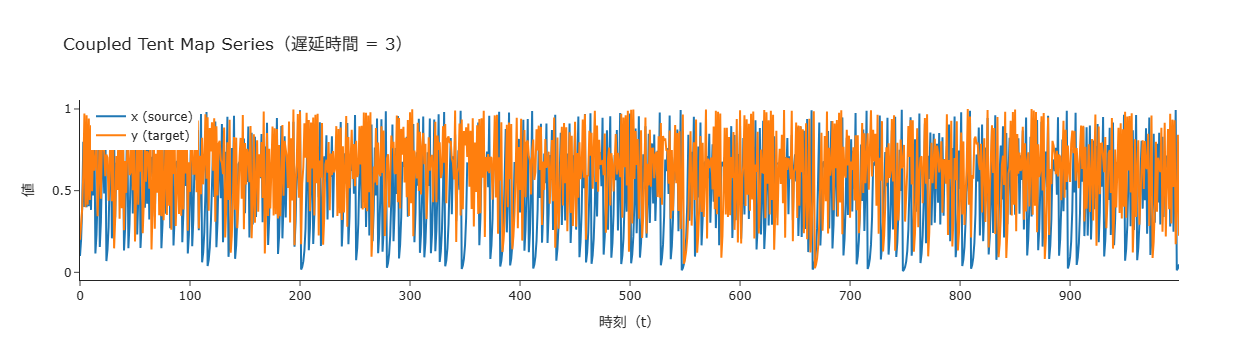

In [60]:
# Tent写像（0〜1に正規化された非線形カオス写像）
def tent_map(x, mu=2.0):
    return mu * x if x < 0.5 else mu * (1 - x)

# 遅延付きカップリング構造による時系列データ生成
def generate_delayed_coupled_tent_map(N=1000, delay=3, epsilon=0.3, x0=0.1, y0=0.2, noise=1e-4):
    """
    Tent写像ベースの非線形カオス時系列を2つ生成（x: 原因, y: 結果）
    y は x の遅延された過去値と自身の過去値の混合をもとに生成される

    Parameters:
    - N: 生成する時系列の長さ
    - delay: x → y への遅延時間
    - epsilon: x の影響の強さ（0〜1）
    - x0, y0: 初期値
    - noise: x に加える微小ノイズ（カオス性維持のため）

    Returns:
    - x: 原因時系列（Tent写像にノイズを加えて生成）
    - y: 結果時系列（x の遅延影響を含む）
    """
    x = [x0]
    y = [y0]
    
    for t in range(1, N):
        x_prev = x[-1] + np.random.uniform(-noise, noise)
        x_next = tent_map(np.clip(x_prev, 0, 1))
        x.append(x_next)

        x_delayed = x[t - delay] if t >= delay else 0.0

        y_input = epsilon * x_delayed + (1 - epsilon) * y[-1]
        y_next = tent_map(np.clip(y_input, 0, 1))
        y.append(y_next)

    return np.array(x), np.array(y)

# ================================
# 🔽 ユーザー入力で遅延時間を指定
# ================================
try:
    user_input = input("遅延時間（delay）を整数で入力してください（例: 3）：")
    true_delay = int(user_input)
    if true_delay < 1:
        raise ValueError
except ValueError:
    print("⚠️ 無効な入力のため、デフォルト値 delay=3 を使用します。")
    true_delay = 3

# ================================
# 🔽 サンプルデータ生成
# ================================
N = 1000
x, y = generate_delayed_coupled_tent_map(N=N, delay=true_delay)

# ================================
# 🔽 Plotlyで可視化
# ================================
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=x,
    mode='lines',
    name='x (source)'
))

fig.add_trace(go.Scatter(
    y=y,
    mode='lines',
    name='y (target)'
))

fig.update_layout(
    title=f'Coupled Tent Map Series（遅延時間 = {true_delay}）',
    xaxis_title='時刻（t）',
    yaxis_title='値',
    template='simple_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

## ➂移動エントロピーの関数定義

In [61]:
# -------------------------------
# 離散化関数（ビン分割に従って連続値を整数カテゴリに変換）
# -------------------------------
def discretize(series, bin_edges):
    # 指定されたビン境界に従って、各値をどのビンに属するかを判定
    return np.digitize(series, bin_edges, right=False)

# -------------------------------
# 単一の遅延時間における Transfer Entropy（X → Y）を計算
# -------------------------------
def compute_transfer_entropy(x, y, delay=1):
    counts = Counter()  # 状態の出現頻度をカウントする辞書
    total = 0  # 有効サンプル数

    # delayを考慮した時系列走査（1ステップ未来のyを予測するため）
    for t in range(delay, len(x) - 1):
        x_p = x[t - delay]   # 遅延されたx（原因）
        y_p = y[t - delay]   # 遅延されたy（コンテキスト）
        y_t = y[t]           # 現在のy（結果）

        # 組み合わせごとの出現頻度をカウント
        counts[(y_t, y_p, x_p)] += 1
        counts[('cond', y_p, x_p)] += 1      # P(y_p, x_p)
        counts[('marg_y', y_t, y_p)] += 1    # P(y_t, y_p)
        counts[('context', y_p)] += 1        # P(y_p)

        total += 1

    # TEの計算（対数情報量ベース）
    te = 0.0
    for key in counts:
        if not isinstance(key[0], (int, np.integer)):
            continue  # 'cond' などの補助キーはスキップ

        y_t, y_p, x_p = key
        p_joint = counts[(y_t, y_p, x_p)] / total
        p_cond = counts[('cond', y_p, x_p)] / total
        p_marg = counts[('marg_y', y_t, y_p)] / total
        p_context = counts[('context', y_p)] / total

        # 情報量の項： log [P(y_t | y_p, x_p) / P(y_t | y_p)]
        if p_joint > 0 and p_cond > 0 and p_marg > 0 and p_context > 0:
            te += p_joint * log2((p_joint * p_context) / (p_cond * p_marg))

    return te

# -------------------------------
# 遅延時間を探索して最大のTransfer Entropyを返す関数
# -------------------------------
def calculate_max_te_independent_bins(x_continuous, y_continuous, bin_edges_x, bin_edges_y, delay_range=(1, 10)):
    """
    Parameters:
    - x_continuous: np.array, Xの連続値時系列
    - y_continuous: np.array, Yの連続値時系列
    - bin_edges_x: list of float, x用の離散化ビン境界
    - bin_edges_y: list of float, y用の離散化ビン境界
    - delay_range: tuple(int, int), 探索する遅延範囲（例：(1, 10)）

    Returns:
    - dict: 各方向の最大TEとそのラグ、および各遅延ごとのTE値を含む
    """
    # 各系列をビン分割して離散化
    x_d = discretize(np.asarray(x_continuous), bin_edges_x)
    y_d = discretize(np.asarray(y_continuous), bin_edges_y)

    # 各遅延におけるTE値を格納する辞書
    te_xy_all = {}  # X→Y
    te_yx_all = {}  # Y→X

    # 指定された遅延範囲で探索
    for d in range(delay_range[0], delay_range[1] + 1):
        te_xy_all[d] = compute_transfer_entropy(x_d, y_d, delay=d)
        te_yx_all[d] = compute_transfer_entropy(y_d, x_d, delay=d)

    # 最大TEを与える遅延を取得
    max_lag_xy = max(te_xy_all, key=te_xy_all.get)
    max_lag_yx = max(te_yx_all, key=te_yx_all.get)

    return {
        'TE_X→Y': te_xy_all[max_lag_xy],      # 最大のX→Y TE値
        'lag_X→Y': max_lag_xy,               # 最大TEを与えたラグ（X→Y）
        'TE_Y→X': te_yx_all[max_lag_yx],      # 最大のY→X TE値
        'lag_Y→X': max_lag_yx,               # 最大TEを与えたラグ（Y→X）
        'te_all_X_to_Y': te_xy_all,          # 各ラグにおけるX→YのTE一覧
        'te_all_Y_to_X': te_yx_all           # 各ラグにおけるY→XのTE一覧
    }


## ④ 移動エントロピーの実行と結果出力

- **引数1：2つの時系列データ（x, y）**  
  解析対象となる連続値の時系列データ。

- **引数2：確率分布を推定するための離散化条件（bin_edges_x, bin_edges_y）**  
  移動エントロピーは、確率分布（状態の出現頻度）に基づいて計算されます。  
  しかし、連続値のままだと「すべての値が異なる」ため、頻度が安定せず確率が推定できません。  
  そのため、離散化（ビン分割）により、状態を明確に定義します。

- **引数3：探索する遅延範囲（例：1〜10）**  
  時系列の遅延（ラグ）によって因果関係が変わるため、  
  1つ前〜10個前までのデータポイントを使って、どのタイミングで最大の影響が現れるかを探索します。


In [70]:
# xとyで個別にビンを設定
bin_edges_x = [0.0, 0.33, 0.66, 1.0]  # 3ビン
bin_edges_y = [0.0, 0.33, 0.66, 1.0]  # 3ビン

# 移動エントロピー実行
result = calculate_max_te_independent_bins(
    x_continuous = x,
    y_continuous = y,
    bin_edges_x = bin_edges_x,      # x用の離散化条件
    bin_edges_y = bin_edges_y,    # y用の離散化条件
    delay_range = (1, 10)
)

# TE結果表示
te_xy = result['TE_X→Y']
lag_xy = result['lag_X→Y']
te_yx = result['TE_Y→X']
lag_yx = result['lag_Y→X']

print(f"TE(X→Y): {te_xy:.4f} (Lag: {lag_xy})")
print(f"TE(Y→X): {te_yx:.4f} (Lag: {lag_yx})")

# 因果関係の方向と伝播時間を解釈して表示
print("\n--- 因果解析結果 ---")
if te_xy > te_yx:
    print(f"✅ X（原因）→ Y（結果）に因果関係あり（伝播遅延: {lag_xy}）")
elif te_yx > te_xy:
    print(f"✅ Y（原因）→ X（結果）に因果関係あり（伝播遅延: {lag_yx}）")
else:
    print("⚠️ 有意な因果関係は検出されませんでした（TEが同程度）")

TE(X→Y): 0.1716 (Lag: 3)
TE(Y→X): 0.0108 (Lag: 9)

--- 因果解析結果 ---
✅ X（原因）→ Y（結果）に因果関係あり（伝播遅延: 3）


## ⑤ TE値と遅延（Lag）の関係を可視化

このステップでは、**Transfer Entropy（TE）と遅延時間（Lag）との関係**を可視化します。

---

### 📊 因果関係の遅延構造を視覚的に確認

以下の2つの系列について、それぞれの遅延 \\( \tau \\) に対する TE 値を折れ線グラフでプロットしています：

- **TE(X→Y)**：`x` が `y` に与える影響（遅延付き）  
- **TE(Y→X)**：`y` が `x` に与える影響（遅延付き）

---

### 🟦 グラフの構成

- **横軸（x軸）**：遅延時間（Lag）  
- **縦軸（y軸）**：移動エントロピー（Transfer Entropy）の値  
- それぞれの系列において、**最大のTE値を示すラグ位置に縦線**を表示し、因果構造が最も強い遅延タイミングを示します。

---

### 🎯 可視化の目的

- X→Y, Y→X の**因果の方向性と強さの違い**を確認
- TEが最大となる**遅延時間（伝播タイミング）**を特定

---

この可視化により、どの方向に、どのタイミングで、どれほどの情報伝達があるかを直感的に把握できます。


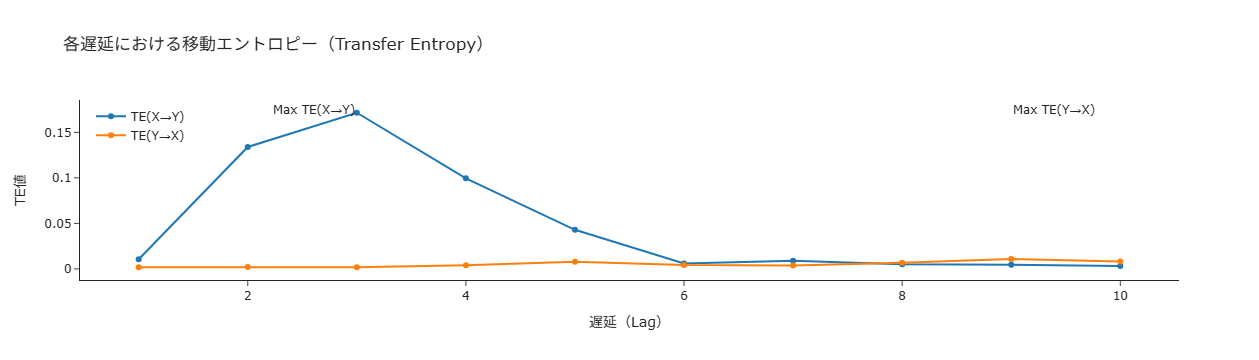

In [68]:
# Plotlyで TE vs Lag を可視化
fig = go.Figure()

# TE(X→Y)
fig.add_trace(go.Scatter(
    x=list(result['te_all_X_to_Y'].keys()),
    y=list(result['te_all_X_to_Y'].values()),
    mode='lines+markers',
    name='TE(X→Y)'
))

# TE(Y→X)
fig.add_trace(go.Scatter(
    x=list(result['te_all_Y_to_X'].keys()),
    y=list(result['te_all_Y_to_X'].values()),
    mode='lines+markers',
    name='TE(Y→X)'
))

# 最大TE位置に縦線
fig.add_vline(
    x=result['lag_X→Y'],
    line=dict(color="blue", dash="dash"),
    annotation_text="Max TE(X→Y)",
    annotation_position="top left"
)
fig.add_vline(
    x=result['lag_Y→X'],
    line=dict(color="orange", dash="dash"),
    annotation_text="Max TE(Y→X)",
    annotation_position="top right"
)

# レイアウト調整
fig.update_layout(
    title="各遅延における移動エントロピー（Transfer Entropy）",
    xaxis_title="遅延（Lag）",
    yaxis_title="TE値",
    legend=dict(x=0.01, y=0.99),
    template="simple_white"
)

fig.show()